In [1]:
# Cell 1: Imports
import os
import re
import glob
import joblib
from collections import defaultdict
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import gc

In [27]:
small_datasets = set(["zcta5", "aerowaythingnodesorted", "craftwaysorted", "arealm", "emergencythingwaysorted", "historicthingwaysorted", "aerowaythingwaysorted"])
big_datasets = set(['powerthingnodesorted', 'yago2', 'powerthingwaysorted', 'barrierthingwaysorted', 'cyclewaythingwaysorted', 'areawater', 'leisurewaysorted'])

def is_small_dataset(dataset_name):    
    return dataset_name in small_datasets

def is_big_dataset(dataset_name):
    return dataset_name in big_datasets

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import median_abs_deviation

def plot_min_y_performance(metric='MAE', central_tendency='mean', filter="contain"):
    """
    Plot performance (MAE or MAPE) against min_y values for all models
    
    Parameters:
    - metric: 'MAE' or 'MAPE'
    - central_tendency: 'mean' (with std deviation) or 'median' (with MAD)
    """
    # Load results
    results_df = pd.read_csv(f"{filter}_min_y_experiment_results_20.csv")
    
    # Check if file was loaded correctly
    if results_df.empty:
        print("Error: No data found in min_y_experiment_results.csv")
        return
    
    # Get unique models
    models = results_df['model'].unique()
    
    # Set up the plot
    plt.figure(figsize=(12, 8))
    
    # Color palette
    colors = sns.color_palette("deep", len(models))

    # print(results_df)

    # results_df = results_df[results_df['dataset'].apply(is_small_dataset)]
    
    # For each model
    for i, model_name in enumerate(models):
        # if model_name == 'NN': continue
        model_data = results_df[results_df['model'] == model_name]
        
        # Group by min_y and calculate statistics based on central tendency choice
        if central_tendency == 'mean':
            # Use mean and standard deviation
            stats = model_data.groupby('min_y')[metric].agg(['mean', 'std']).reset_index()
            central_value = 'mean'
            variation = 'std'
            ylabel_prefix = 'Average'
        else:
            # Use median and median absolute deviation (MAD)
            stats = pd.DataFrame()
            stats['min_y'] = model_data['min_y'].unique()
            stats = stats.sort_values('min_y')
            
            # Calculate median and MAD for each min_y value
            median_values = []
            mad_values = []
            
            for min_y_val in stats['min_y']:
                subset = model_data[model_data['min_y'] == min_y_val][metric]
                median_values.append(subset.median())
                mad_values.append(median_abs_deviation(subset, scale=1.0))
            
            stats['median'] = median_values
            stats['mad'] = mad_values
            central_value = 'median'
            variation = 'mad'
            ylabel_prefix = 'Median'

        stats = stats[stats['min_y'] < 500000]
        
        # Plot central tendency line
        plt.plot(stats['min_y'], stats[central_value], marker='o', linewidth=2, 
                 label=model_name if model_name != 'NN' else 'MLP', color=colors[i])
        
        # Plot variation margin
        plt.fill_between(
            stats['min_y'],
            (stats[central_value] - stats[variation]).clip(lower=0),
            stats[central_value] + stats[variation],
            alpha=0.2,
            color=colors[i]
        )
    
    # Use log scale for x-axis as min_y values follow logarithmic pattern
    plt.xscale('log')  # symlog handles zero values
    plt.yscale('log')  # Log scale for y-axis to handle wide range of values
    
    # Add grid, labels and legend
    plt.grid(alpha=0.3)
    plt.xlabel('Minimum Number of Objects')
    plt.ylabel(f'{metric}')
    
    variation_label = "Standard Deviation" if central_tendency == 'mean' else "MAD"
    # plt.title(f'Model performance ({metric}, {central_tendency} ± {variation_label}) vs Minimum Y threshold')
    plt.legend()
    plt.tight_layout()
    
    # Save figure
    filename = f'{filter}_min_y_vs_{metric.lower()}_{central_tendency}.pdf'
    plt.savefig(filename, dpi=300)
    print(f"Saved figure to: {filename}")
    
    plt.show()

Saved figure to: contain_min_y_vs_mae_mean.pdf


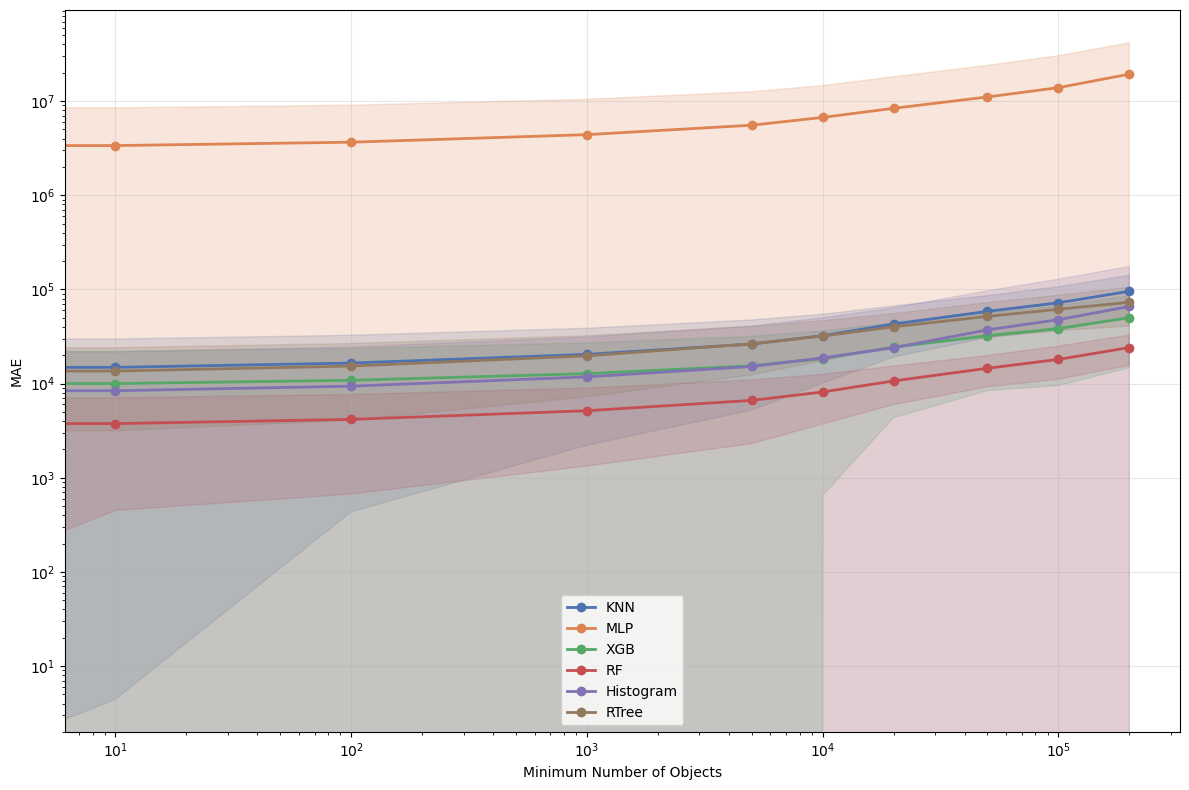

Saved figure to: contain_min_y_vs_mape_mean.pdf


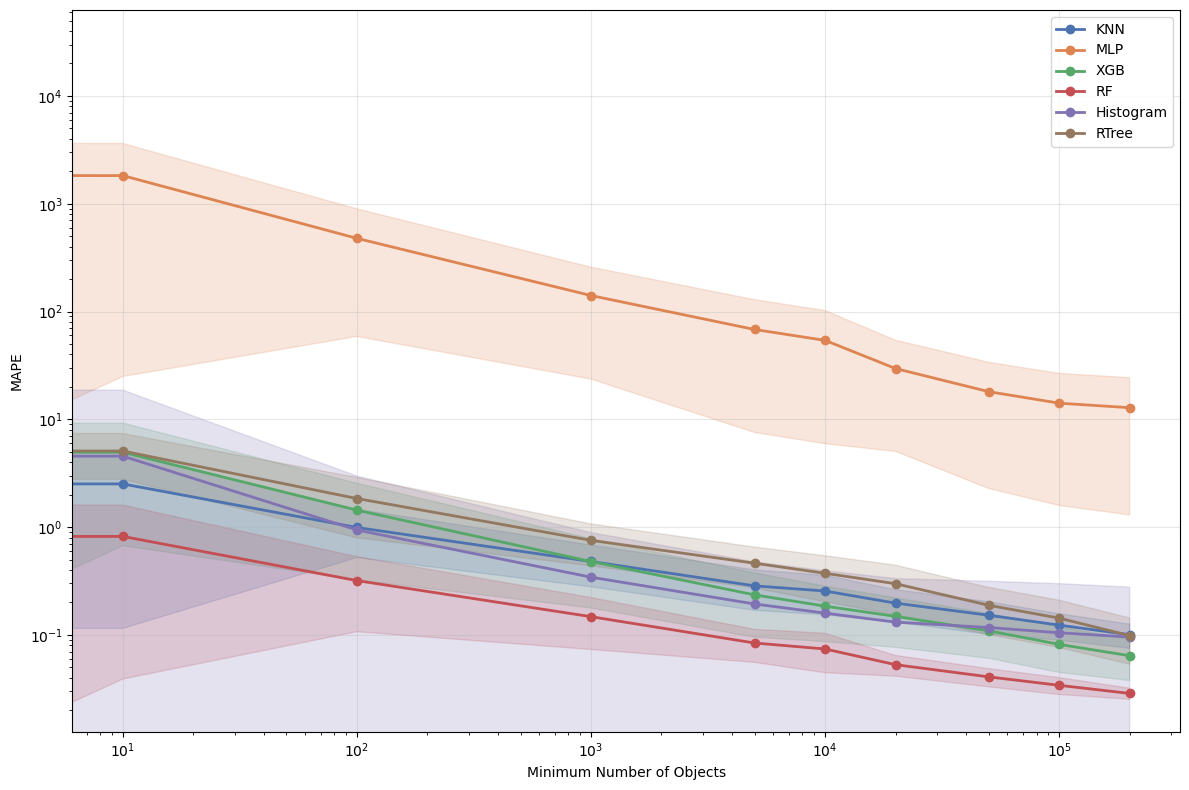

In [40]:
for metric in ['MAE', 'MAPE']:
    for central_tendency in ['mean']:
        plot_min_y_performance(metric=metric, central_tendency=central_tendency, filter="contain")

     model dataset  min_y           MAE      MAPE  sample_count
0      KNN   yago2      0   5264.343370  0.219787        179789
1      KNN   yago2     10   5314.662081  0.092247        178075
2      KNN   yago2    100   5387.385309  0.083555        175659
3      KNN   yago2   1000   6037.528492  0.073788        156537
4      KNN   yago2   5000   7717.530166  0.068986        121485
..     ...     ...    ...           ...       ...           ...
819  RTree  arealm    100  11712.486865  4.432293           571
820  RTree  arealm   1000  17080.449857  1.175991           349
821  RTree  arealm   5000  24424.444444  0.672225           225
822  RTree  arealm  10000  29643.040000  0.629630           175
823  RTree  arealm  20000  37035.637097  0.536014           124

[824 rows x 6 columns]
Saved figure to: intersect_min_y_vs_mae_mean.pdf


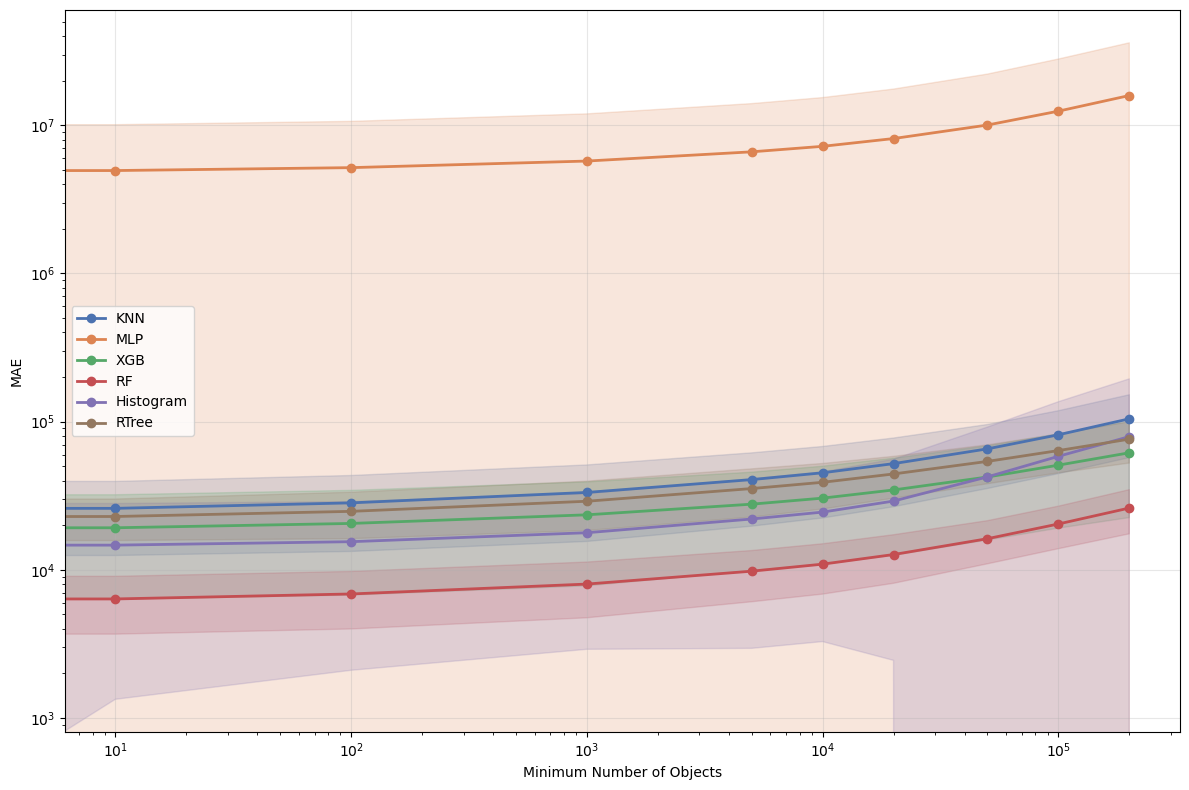

     model dataset  min_y           MAE      MAPE  sample_count
0      KNN   yago2      0   5264.343370  0.219787        179789
1      KNN   yago2     10   5314.662081  0.092247        178075
2      KNN   yago2    100   5387.385309  0.083555        175659
3      KNN   yago2   1000   6037.528492  0.073788        156537
4      KNN   yago2   5000   7717.530166  0.068986        121485
..     ...     ...    ...           ...       ...           ...
819  RTree  arealm    100  11712.486865  4.432293           571
820  RTree  arealm   1000  17080.449857  1.175991           349
821  RTree  arealm   5000  24424.444444  0.672225           225
822  RTree  arealm  10000  29643.040000  0.629630           175
823  RTree  arealm  20000  37035.637097  0.536014           124

[824 rows x 6 columns]
Saved figure to: intersect_min_y_vs_mape_mean.pdf


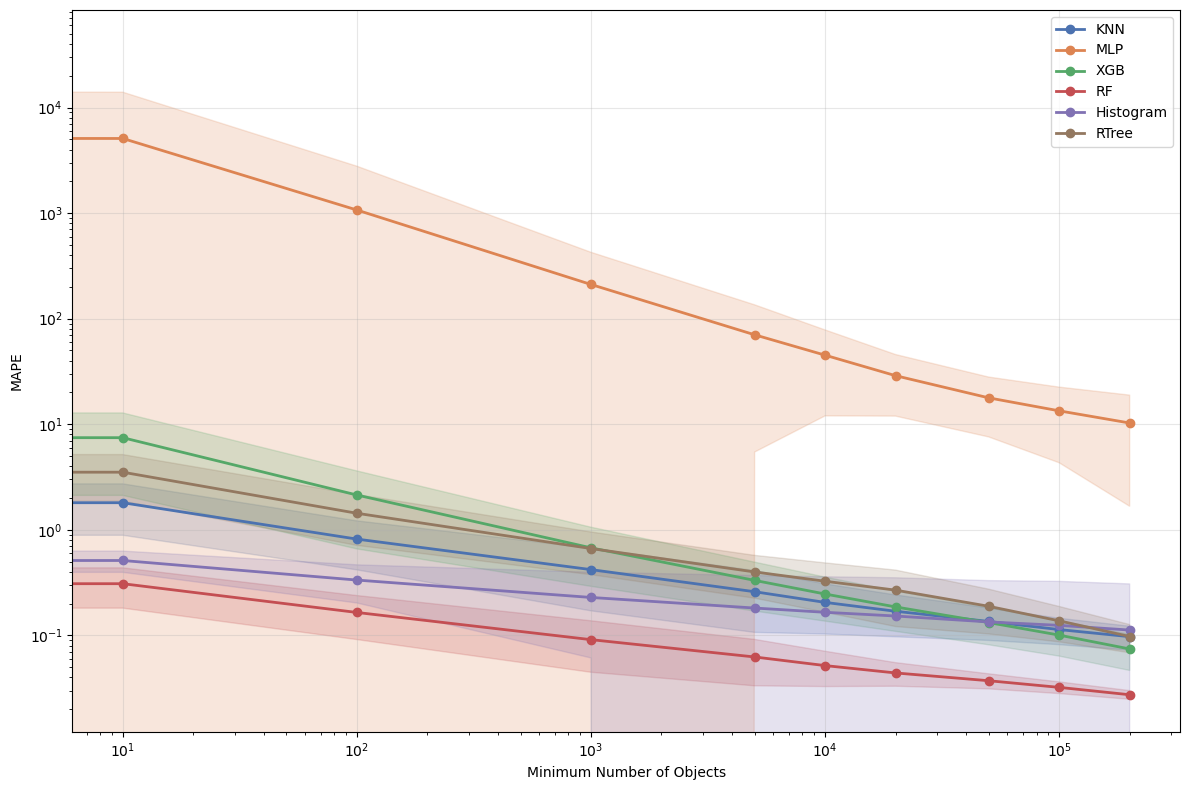

In [30]:
for metric in ['MAE', 'MAPE']:
    for central_tendency in ['mean']:
        plot_min_y_performance(metric=metric, central_tendency=central_tendency, filter="intersect")

         model               dataset  min_y           MAE      MAPE  \
0          KNN  powerthingnodesorted      0  23119.809049  0.965691   
1          KNN  powerthingnodesorted     10  23195.811234  0.584276   
2          KNN  powerthingnodesorted    100  23214.813244  0.372870   
3          KNN  powerthingnodesorted   1000  23297.468807  0.232757   
4          KNN  powerthingnodesorted   5000  23500.815678  0.140949   
..         ...                   ...    ...           ...       ...   
679  Histogram        craftwaysorted    100   4922.696828  0.583250   
680  Histogram        craftwaysorted   1000   6165.923774  0.543335   
681  Histogram        craftwaysorted   5000   8974.055443  0.466389   
682  Histogram        craftwaysorted  10000  11034.351704  0.420217   
683  Histogram        craftwaysorted  20000  14101.174079  0.367751   

     sample_count  
0          420503  
1          419096  
2          418605  
3          416170  
4          408462  
..            ...  
679    

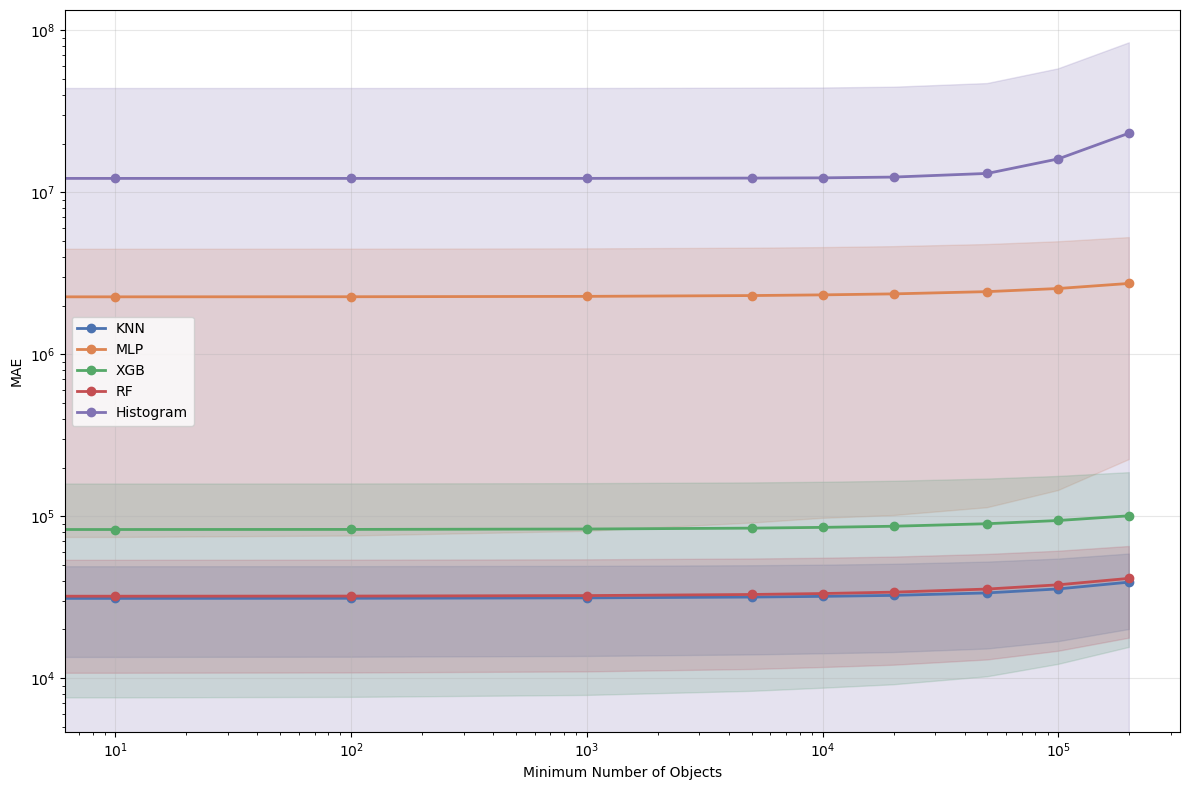

         model               dataset  min_y           MAE      MAPE  \
0          KNN  powerthingnodesorted      0  23119.809049  0.965691   
1          KNN  powerthingnodesorted     10  23195.811234  0.584276   
2          KNN  powerthingnodesorted    100  23214.813244  0.372870   
3          KNN  powerthingnodesorted   1000  23297.468807  0.232757   
4          KNN  powerthingnodesorted   5000  23500.815678  0.140949   
..         ...                   ...    ...           ...       ...   
679  Histogram        craftwaysorted    100   4922.696828  0.583250   
680  Histogram        craftwaysorted   1000   6165.923774  0.543335   
681  Histogram        craftwaysorted   5000   8974.055443  0.466389   
682  Histogram        craftwaysorted  10000  11034.351704  0.420217   
683  Histogram        craftwaysorted  20000  14101.174079  0.367751   

     sample_count  
0          420503  
1          419096  
2          418605  
3          416170  
4          408462  
..            ...  
679    

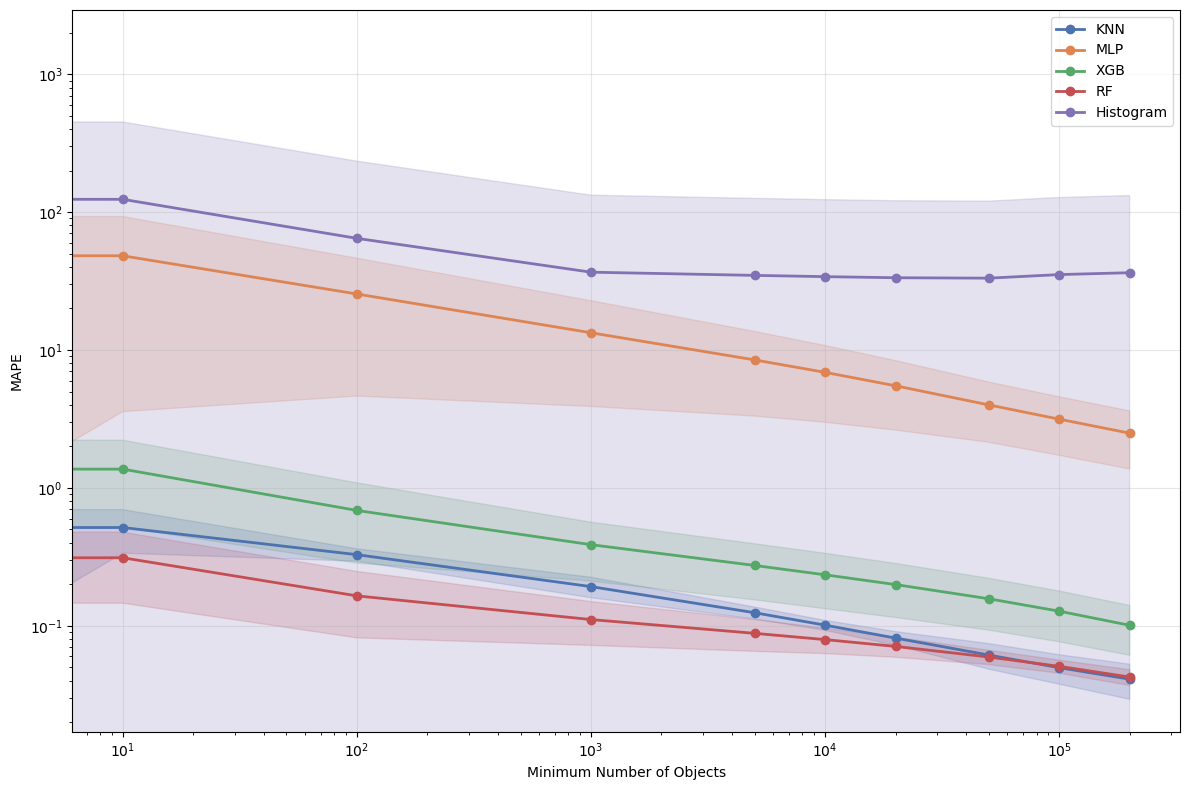

In [31]:
for metric in ['MAE', 'MAPE']:
    for central_tendency in ['mean']:
        plot_min_y_performance(metric=metric, central_tendency=central_tendency, filter="distance")